In [1]:
import pandas as pd
import numpy as np

In [36]:
L='tjx sig fti sanm apc ms cbs car nov tif bby ten m flr cfg all are gt adm'.upper().split(' ')

Merge the price data the same way as the quote and ask data, while for the size variable we sum over each 10 second period.

In [37]:
df=pd.read_csv('Dec_vwap.csv',header=0)


C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def VWAP_calc(ticker,capital):
    df_t=df[df['SYM_ROOT']==ticker]
    D=sorted(list(set(df_t['DATE'])))
    St=[]
    S_t=[]
    for d in D[:9]:
        i=-1
        s=[]
        T=[]
        df_d=df_t[df_t['DATE']==d]
        for j in range(len(df_d['TIME_M'])):
            
            if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
                    s.append(0)
                   
            if np.array(df_d['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_d['TIME_M'])[j][:-13])
                s.append(np.array(df_d['SIZE'])[j])
            else:
                s[i]+=np.array(df_d['SIZE'])[j]
        if '9:30' not in T:
            s=[0]+s
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    hist_mean=np.mean(S_t,axis=0)
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    #print(vol_mean)
    df_d=df_t[df_t['DATE']==D[9]]
    T=[]
    s_start=[]
    p_start=[]
    i=-1
    for j in range(len(df_d['TIME_M'])):
        
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
            
                s_start.append(0)
                p_start.append(p_start[-1])
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p_start.append(np.array(df_d['PRICE'])[j])
            s_start.append(np.array(df_d['SIZE'])[j])
        else:
            s_start[i]+=np.array(df_d['SIZE'])[j]
    if '9:30' not in T:
        s_start=[0]+s_start
        p_start=[0]+p_start
    df_d=df_t[df_t['DATE']==D[-1]]
    T=[]
    s_end=[]
    p_end=[]
    i=-1
    for j in range(len(df_d['TIME_M'])):
        
        if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
           
                s_end.append(0)
                p_end.append(p_end[-1])
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            i+=1
            T.append(str(np.array(df_d['TIME_M'])[j][:-13]))
            p_end.append(np.array(df_d['PRICE'])[j])
            s_end.append(np.array(df_d['SIZE'])[j])
        else:
            s_end[i]+=np.array(df_d['SIZE'])[j]
    if '9:30' not in T:
        s_end=[0]+s_end
        p_end=[0]+p_end
    #print(T)
    Dict_=np.load('data.npy').item()
    p_d=np.array(Dict_[ticker.lower()]['Open'])[53]
    p_s=np.array(Dict_[ticker.lower()]['Open'])[62]
    cap=capital
    size=int(cap/p_d)
    hb,r,pb=execution(hist_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps=execution(hist_mean,size,s_end,p_end)
    size=int(cap/p_d)
    hb,r,pb2=execution(pred_mean,size,s_start,p_start)
    size=int(cap/p_d)
    hs,r,ps2=execution(pred_mean,size,s_end,p_end)
    h,bb=benchmark(size,s_start,p_start)
    h,bs=benchmark(size,s_end,p_end)
    print('2018.12.17 (Buy)Decision Price:'+str(p_d)+' Executed VWAP(historic mean):'+str(round(pb,3))+' Executed VWAP(fitted mean):'+str(round(pb2,3))+' Benchmark VWAP:'+str(round(bb,3)))
    print('2018.12.31 (Sell)Decision Price:'+str(p_s)+' Executed VWAP(historic mean):'+str(round(ps,3))+' Executed VWAP(fitted mean):'+str(round(ps2,3))+' Benchmark VWAP:'+str(round(bs,3)))
    print('IS1:'+str(((pb-p_d)*size+(p_s-ps)*size)/float(capital))+' IS2:'+str(((pb2-p_d)*size+(p_s-ps2)*size)/float(capital)))
    return St,(size*ps-size*pb)/(size*pb),hb,hs,pb,ps,bb,bs,((bb-p_d)*size+(p_s-bs)*size)/float(capital),((pb-p_d)*size+(p_s-ps)*size)/float(capital),((pb2-p_d)*size+(p_s-ps2)*size)/float(capital)
   

In [49]:
shortfall=[]
shortfall2=[]
benchmark_sf=[]
for i in L:
  
    print(i)
    record=VWAP_calc(i,100000)
    IS=record[-1]
    IS2=record[-2]
    shortfall.append(IS2)
    shortfall2.append(IS)
    benchmark_sf.append(record[-3])

TJX
2018.12.17 (Buy)Decision Price:45.7799 Executed VWAP(historic mean):44.491 Executed VWAP(fitted mean):44.482 Benchmark VWAP:44.545
2018.12.31 (Sell)Decision Price:44.6543 Executed VWAP(historic mean):44.244 Executed VWAP(fitted mean):44.248 Benchmark VWAP:44.238
IS1:-0.019206044452342894 IS2:-0.01947669220672932
SIG
2018.12.17 (Buy)Decision Price:32.1531 Executed VWAP(historic mean):31.794 Executed VWAP(fitted mean):31.798 Benchmark VWAP:31.774
2018.12.31 (Sell)Decision Price:30.991 Executed VWAP(historic mean):31.298 Executed VWAP(fitted mean):31.298 Benchmark VWAP:31.217
IS1:-0.02071427782513429 IS2:-0.020607731073269932
FTI
2018.12.17 (Buy)Decision Price:19.96 Executed VWAP(historic mean):19.917 Executed VWAP(fitted mean):19.92 Benchmark VWAP:19.909
2018.12.31 (Sell)Decision Price:20.04 Executed VWAP(historic mean):19.658 Executed VWAP(fitted mean):19.644 Benchmark VWAP:19.617
IS1:0.01698911487330281 IS2:0.017820404873234132
SANM
2018.12.17 (Buy)Decision Price:24.28 Executed VWA

In [50]:
print('Historic mean Shortfall:'+str(np.mean(shortfall)))
print('Fitted mean Shortfall:'+str(np.mean(shortfall2)))
print('Benchmark Shortfall:'+str(np.mean(benchmark_sf)))
print('Period Theoretical Return:'+str(-0.037161334639139516))

Historic mean Shortfall:0.00013188984126281275
Fitted mean Shortfall:7.982008842660178e-05
Benchmark Shortfall:0.00045759983010118017
Period Theoretical Return:-0.037161334639139516


In [10]:
def execution(target_percentage,size,real_volume,real_price):
    i=0
    VWAP=0
    size_=size
    history=[]
    while size>0 and i<len(real_volume):
        goal=target_percentage[i]*size_
        if i==len(real_volume)-1:
            
            realized=min(size,real_volume[i])
        else:
            realized=min(goal,real_volume[i])
        realized=min(realized,size)
        VWAP+=realized*real_price[i]
        history.append(realized)
        
        i+=1
        size-=realized
    history=np.array(history)
    return history,size,VWAP/float(np.sum(history))
def benchmark(size,real_volume,real_price):
    history=np.array(real_volume)*size/float(sum(real_volume))
    VWAP=np.sum(history*np.array(real_price))
    return history,VWAP/float(np.sum(history))


# Plotting cumulative volume percentage distribution

In [40]:

try:    
    df_t=df[df['SYM_ROOT']==L[1]]
    D=list(set(df_t['DATE']))
    St=[]
    S_t=[]
    for d in D[:-1]:
        i=-1
        s=[]
        T=[]
        df_d=df_t[df_t['DATE']==d]
        for j in range(len(df_d['TIME_M'])):
            
            if len(T)>0 and (int(np.array(df_d['TIME_M'])[j][-15:-13])-int(T[-1][-2:]))>1:
                    s.append(0)
                   
            if np.array(df_d['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_d['TIME_M'])[j][:-13])
                s.append(np.array(df_d['SIZE'])[j])
            else:
                s[i]+=np.array(df_d['SIZE'])[j]
        if '9:30' not in T:
            s=[0]+s
            
        if len(s)==30:
            St+=s
            S_t.append(s)
    St=np.array(St,dtype=float)
    S_t=np.array(S_t,dtype=float)
    for i in range(len(S_t)):
        S_t[i,:]=S_t[i,:]/float(np.sum(S_t[i,:]))
    T=[]
    for i in range(int(len(St)/30)):
        for j in range(30):
            T.append(j)
    T=np.array(T)
    #print(T)
    X=[]
    for i in range(len(T)):
        t=T[i]
        X.append([t,t**2,t**3,t**4,t**5])
    X=np.array(X)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X,St)
    pred_vol=regr.predict(X[:30,:])
    
    pred_mean=pred_vol/np.sum(pred_vol)
    vol_mean=np.mean(S_t,axis=0)
except:
    pass


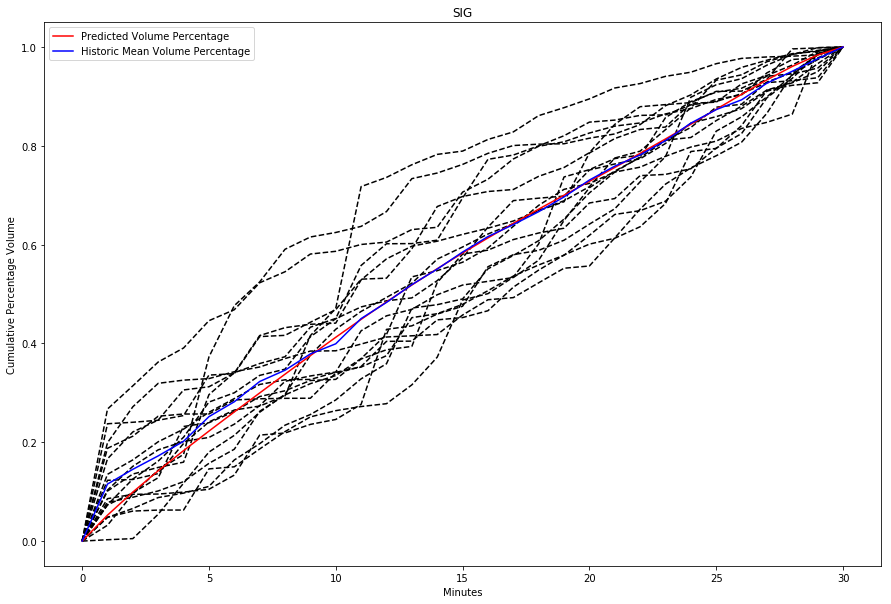

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot_cumper(St,mean,pred,name):
    plt.figure(figsize=(15,10))
    for i in range(len(St)):
        c=[0]+[np.sum(St[i,:j+1]) for j in range(len(St[i]))]
        plt.plot(c,'k--')
    c=[0]+[np.sum(pred[:j+1]) for j in range(len(pred))]
    plt.plot(c,'r',label='Predicted Volume Percentage')
    c=[0]+[np.sum(mean[:j+1]) for j in range(len(mean))]
    plt.plot(c,'b',label='Historic Mean Volume Percentage')
    plt.title(name)
    plt.xlabel('Minutes')
    plt.ylabel('Cumulative Percentage Volume')
    plt.legend()
plot_cumper(S_t,vol_mean,pred_mean,L[1])